# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from prophet import Prophet

from tqdm import tqdm_notebook


# Load dataset

In [2]:
data = pd.read_csv(r'C:\Users\Victo\Time series model/craigslist_vehicles.csv')
data.head()

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,...,type,paint_color,image_url,description,county,state,lat,long,posting_date,removal_date
0,362773,7307679724,https://abilene.craigslist.org/ctd/d/abilene-2...,abilene,https://abilene.craigslist.org,4500,2002.0,bmw,x5,NaN,...,NaN,NaN,https://images.craigslist.org/00m0m_iba78h8ty9...,"$4,500 Cash 2002 BMW X5 8 cylinder 4.4L moto...",NaN,tx,32.401556,-99.884713,2021-04-16 00:00:00+00:00,2021-05-02 00:00:00+00:00
1,362712,7311833696,https://abilene.craigslist.org/ctd/d/abilene-2...,abilene,https://abilene.craigslist.org,4500,2002.0,bmw,x5,NaN,...,NaN,NaN,https://images.craigslist.org/00m0m_iba78h8ty9...,"$4,500 Cash 2002 BMW X5 8 cylinder 4.4L moto...",NaN,tx,32.401556,-99.884713,2021-04-24 00:00:00+00:00,2021-04-28 00:00:00+00:00
2,362722,7311441996,https://abilene.craigslist.org/ctd/d/abilene-2...,abilene,https://abilene.craigslist.org,4900,2006.0,toyota,camry,excellent,...,sedan,silver,https://images.craigslist.org/00808_5FkOw2aGjA...,2006 TOYOTA CAMRY LE Sedan Ready To Upgrade ...,NaN,tx,32.453848,-99.787900,2021-04-23 00:00:00+00:00,2021-05-25 00:00:00+00:00
3,362771,7307680715,https://abilene.craigslist.org/ctd/d/abilene-2...,abilene,https://abilene.craigslist.org,6500,2008.0,ford,expedition,NaN,...,NaN,NaN,https://images.craigslist.org/00M0M_i9CoFvVq8o...,$6500.00 2008 Ford Expedition 8 cylinder 5.4L...,NaN,tx,32.401556,-99.884713,2021-04-16 00:00:00+00:00,2021-04-26 00:00:00+00:00
4,362710,7311834578,https://abilene.craigslist.org/ctd/d/abilene-2...,abilene,https://abilene.craigslist.org,6500,2008.0,ford,expedition,NaN,...,NaN,NaN,https://images.craigslist.org/00M0M_i9CoFvVq8o...,$6500.00 2008 Ford Expedition 8 cylinder 5.4L...,NaN,tx,32.401556,-99.884713,2021-04-24 00:00:00+00:00,2021-05-12 00:00:00+00:00


# Data Cleaning and Feature Engineering

In [3]:
drop_col = ['description', 'image_url', 'region_url', 'url', 'id', 'Unnamed: 0', 'county', 'state']
data.drop(drop_col, axis=1, inplace=True)
data.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,lat,long,posting_date,removal_date
0,abilene,4500,2002.0,bmw,x5,NaN,NaN,gas,184000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,32.401556,-99.884713,2021-04-16 00:00:00+00:00,2021-05-02 00:00:00+00:00
1,abilene,4500,2002.0,bmw,x5,NaN,NaN,gas,184000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,32.401556,-99.884713,2021-04-24 00:00:00+00:00,2021-04-28 00:00:00+00:00
2,abilene,4900,2006.0,toyota,camry,excellent,4 cylinders,gas,184930.0,clean,automatic,NaN,fwd,NaN,sedan,silver,32.453848,-99.787900,2021-04-23 00:00:00+00:00,2021-05-25 00:00:00+00:00
3,abilene,6500,2008.0,ford,expedition,NaN,NaN,gas,206000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,32.401556,-99.884713,2021-04-16 00:00:00+00:00,2021-04-26 00:00:00+00:00
4,abilene,6500,2008.0,ford,expedition,NaN,NaN,gas,206000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,32.401556,-99.884713,2021-04-24 00:00:00+00:00,2021-05-12 00:00:00+00:00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   year          425675 non-null  float64
 3   manufacturer  409234 non-null  object 
 4   model         421603 non-null  object 
 5   condition     252776 non-null  object 
 6   cylinders     249202 non-null  object 
 7   fuel          423867 non-null  object 
 8   odometer      422480 non-null  float64
 9   title_status  418638 non-null  object 
 10  transmission  424324 non-null  object 
 11  VIN           265838 non-null  object 
 12  drive         296313 non-null  object 
 13  size          120519 non-null  object 
 14  type          334022 non-null  object 
 15  paint_color   296677 non-null  object 
 16  lat           420331 non-null  float64
 17  long          420331 non-null  float64
 18  post

In [5]:
# data.dropna(inplace = True)
# data.info()

In [6]:
data.dtypes

region           object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
lat             float64
long            float64
posting_date     object
removal_date     object
dtype: object

In [7]:
# Fill the missing numerical data with median
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())

# Fill the missing categorical data with mode
categorical_columns = data.select_dtypes(include=['object']).columns
data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])

In [8]:
data.isnull().sum().sum()

0

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   year          426880 non-null  float64
 3   manufacturer  426880 non-null  object 
 4   model         426880 non-null  object 
 5   condition     426880 non-null  object 
 6   cylinders     426880 non-null  object 
 7   fuel          426880 non-null  object 
 8   odometer      426880 non-null  float64
 9   title_status  426880 non-null  object 
 10  transmission  426880 non-null  object 
 11  VIN           426880 non-null  object 
 12  drive         426880 non-null  object 
 13  size          426880 non-null  object 
 14  type          426880 non-null  object 
 15  paint_color   426880 non-null  object 
 16  lat           426880 non-null  float64
 17  long          426880 non-null  float64
 18  post

In [10]:
data.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'lat', 'long', 'posting_date',
       'removal_date'],
      dtype='object')

In [11]:
# Convert 'posting_date' column to datetime data type and make it an index
data['posting_date'] = pd.to_datetime(data['posting_date'])

data.set_index('posting_date', inplace=True)
data.head(2)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,lat,long,removal_date
posting_date,,,,,,,,,,,,,,,,,,,
2021-04-16 00:00:00+00:00,abilene,4500,2002.0,bmw,x5,good,6 cylinders,gas,184000.0,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,32.401556,-99.884713,2021-05-02 00:00:00+00:00
2021-04-24 00:00:00+00:00,abilene,4500,2002.0,bmw,x5,good,6 cylinders,gas,184000.0,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,32.401556,-99.884713,2021-04-28 00:00:00+00:00


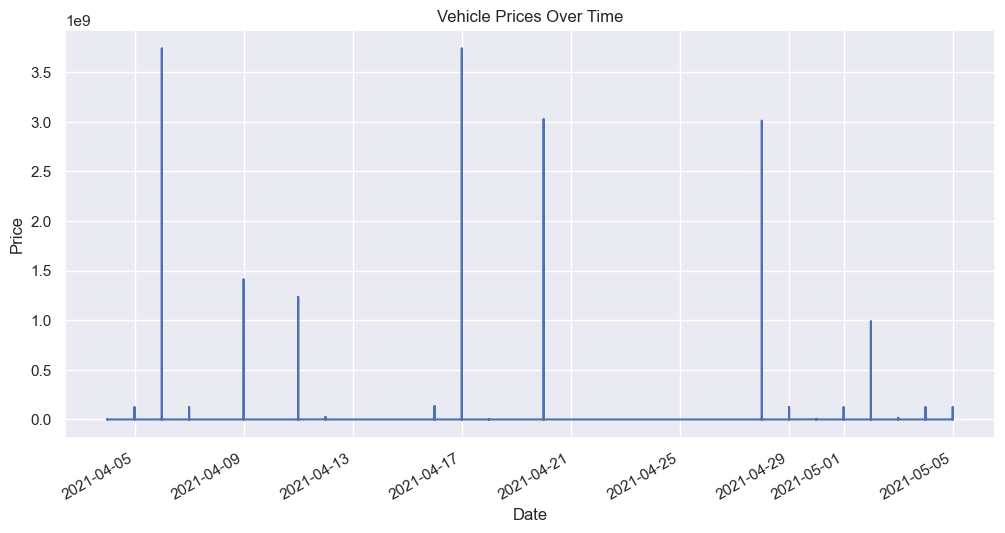

In [12]:
# Time Series Plot
plt.figure(figsize=(12, 6))
data['price'].plot()
plt.title('Vehicle Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

<Figure size 1200x800 with 0 Axes>

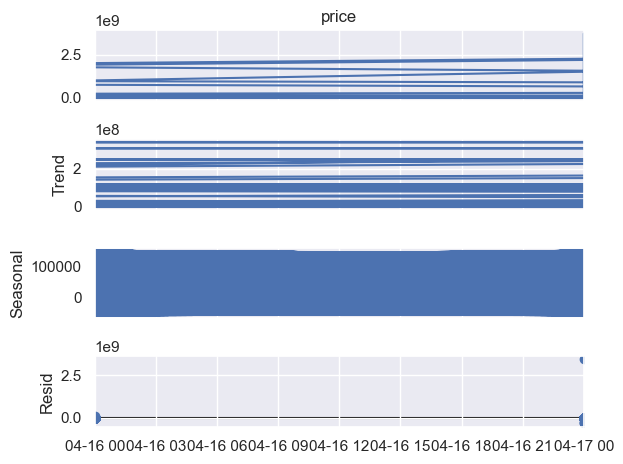

In [13]:
# Seasonal Decomposition
decomposition = seasonal_decompose(data['price'], model='additive', period=12)
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

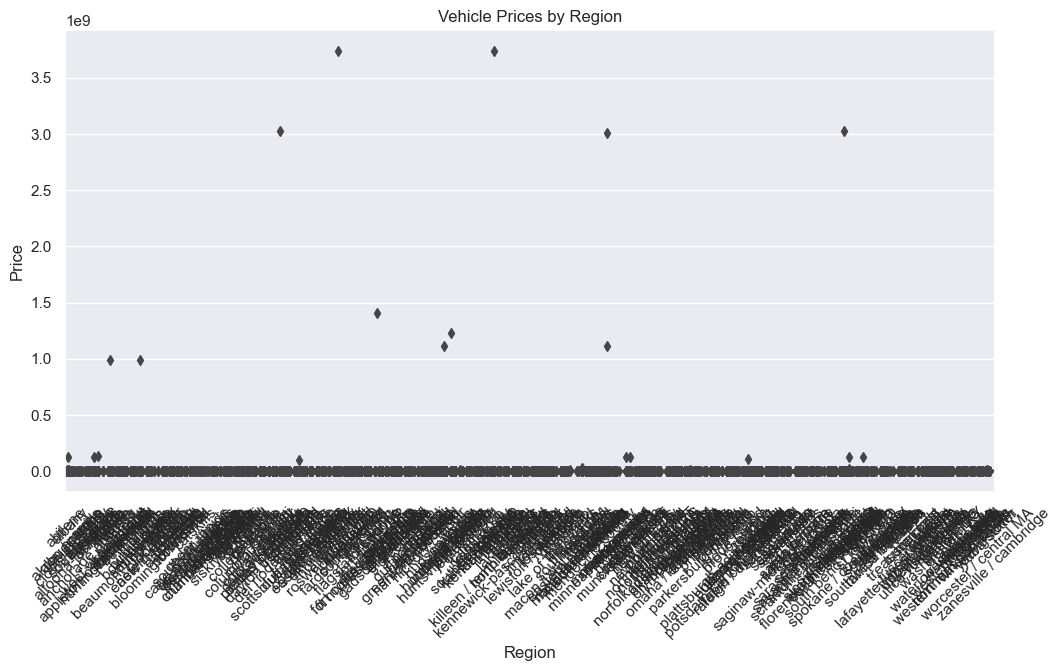

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='region', y='price', data=data)
plt.title('Vehicle Prices by Region')
plt.xlabel('Region')
plt.ylabel('Price')
plt.xticks(rotation= 45)
plt.show()

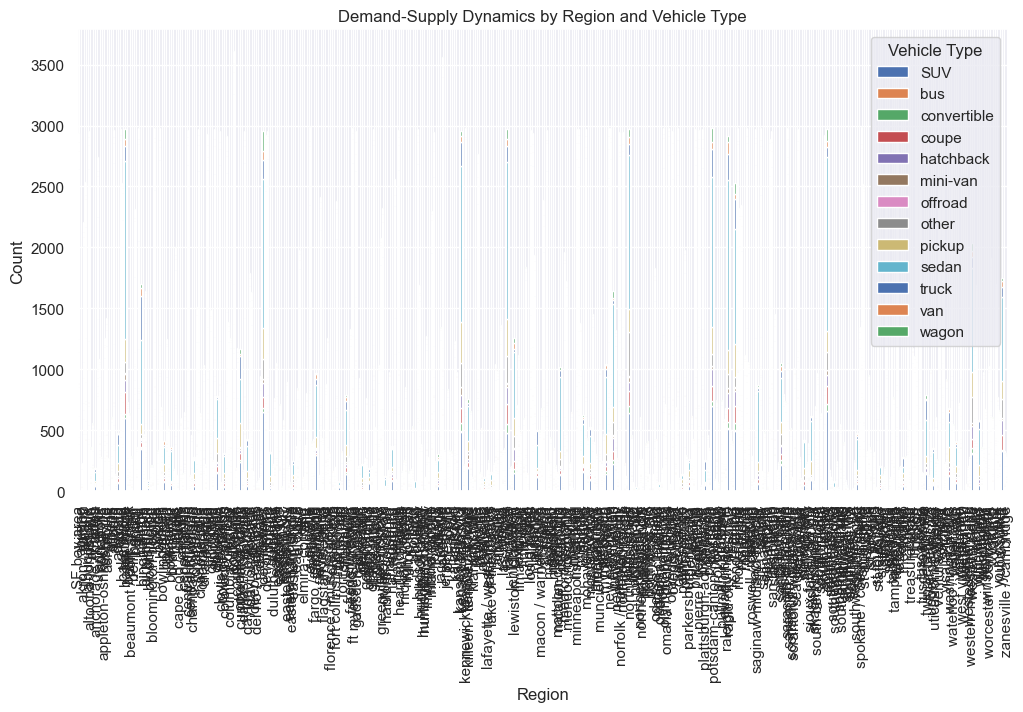

In [15]:
# Grouped Bar Chart
grouped_data = data.groupby(['region', 'type']).size().unstack()
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Demand-Supply Dynamics by Region and Vehicle Type')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Vehicle Type')
plt.show()

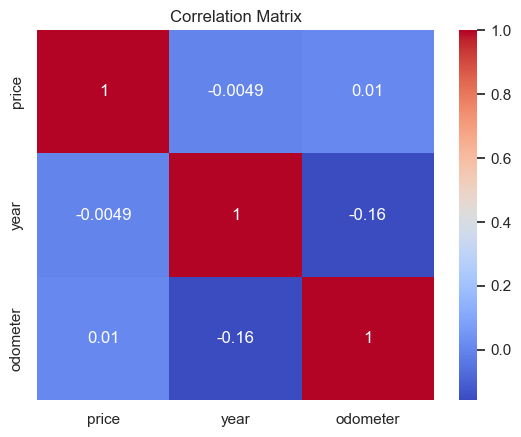

In [16]:
# Exclude 'region' column from correlation matrix calculation
numerical_columns = ['price', 'year', 'odometer']
correlation_matrix = data[numerical_columns].corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Modelling

00:55:31 - cmdstanpy - INFO - Chain [1] start processing
00:55:55 - cmdstanpy - INFO - Chain [1] done processing


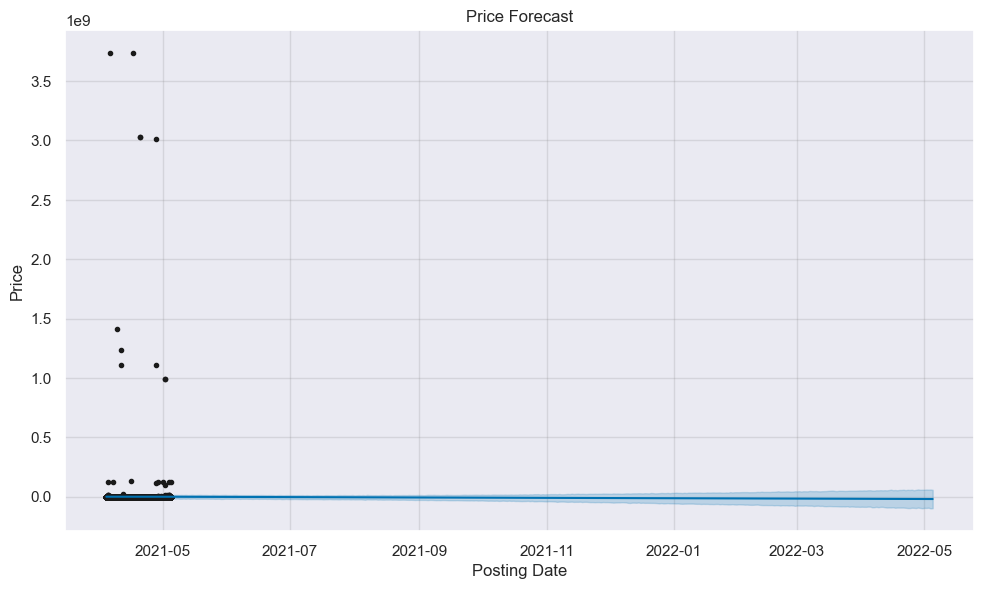

In [17]:
# Prepare the data for Prophet
prophet_data = data.reset_index()[['posting_date', 'price']]
prophet_data.columns = ['ds', 'y']

# Remove timezone from 'ds' column
prophet_data['ds'] = prophet_data['ds'].dt.tz_localize(None)

# Create a Prophet model
model = Prophet()

# Fit the model to the data
model.fit(prophet_data)

# Make future predictions
future = model.make_future_dataframe(periods=365)  # Specify the number of future periods to predict
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast, xlabel='Posting Date', ylabel='Price')
plt.title('Price Forecast')
plt.show()

In [ ]:
from tqdm import tqdm_notebook

from itertools import product
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.price, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data.price - data.price.shift(1)

tsplot(data_diff[1:], lags=30)